In [98]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import VBBinaryLensing

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

In [99]:
# Initialize VBBinaryLensing() class object, set relative accuracy
VBBL = VBBinaryLensing.VBBinaryLensing()
VBBL.RelTol = 1e-03

In [100]:
t  =  np.linspace(7000, 7300, 500)

s = 1.2 # separation between the two lenses in units of total ang. Einstein radii
q = 0.5 # mass ratio: mass of the lens on the right divided by mass of the lens on the left
rho = 0.01 # source radius in Einstein radii of the total mass.
alpha = 0.93 # angle between lens axis and source trajectory
tE = 100.3 # einstein radius crossing time
t0 = 7154. # time of peak magnification
u0 = 0.2 # impact parameter

# Position of the center of the source with respect to the center of mass.
tau = (t - t0)/tE
y1 = -u0*np.sin(alpha) + tau*np.cos(alpha)
y2 = u0*np.cos(alpha) + tau*np.sin(alpha)

mag = np.zeros(len(tau))

# Calculate the magnification at each time 
?VBBL.BinaryLightCurve

params = [np.log(s), np.log(q), u0, alpha, np.log(rho), np.log(tE), t0]
mag = VBBL.BinaryLightCurve(params, t, y1, y2)

In [101]:
# Calculate the cirtical curves and the caustic curves
solutions = VBBL.PlotCrit(s, q) # Returns _sols object containing n crit. curves followed by n caustic curves
print(type(solutions))

<class 'VBBinaryLensing._sols'>


In [102]:
# generator function iterating over _sols, _curve, or _point objects 
# making use of the next keyword
def iterate_from(item):
    while item is not None:
        yield item
        item = item.next

curves = []
for curve in iterate_from(solutions.first):
    for point in iterate_from(curve.first):
        curves.append((point.x1, point.x2))
        
critical_curves = np.array(curves[:int(len(curves)/2)])
caustic_curves = np.array(curves[int(len(curves)/2):])

(-1, 1)

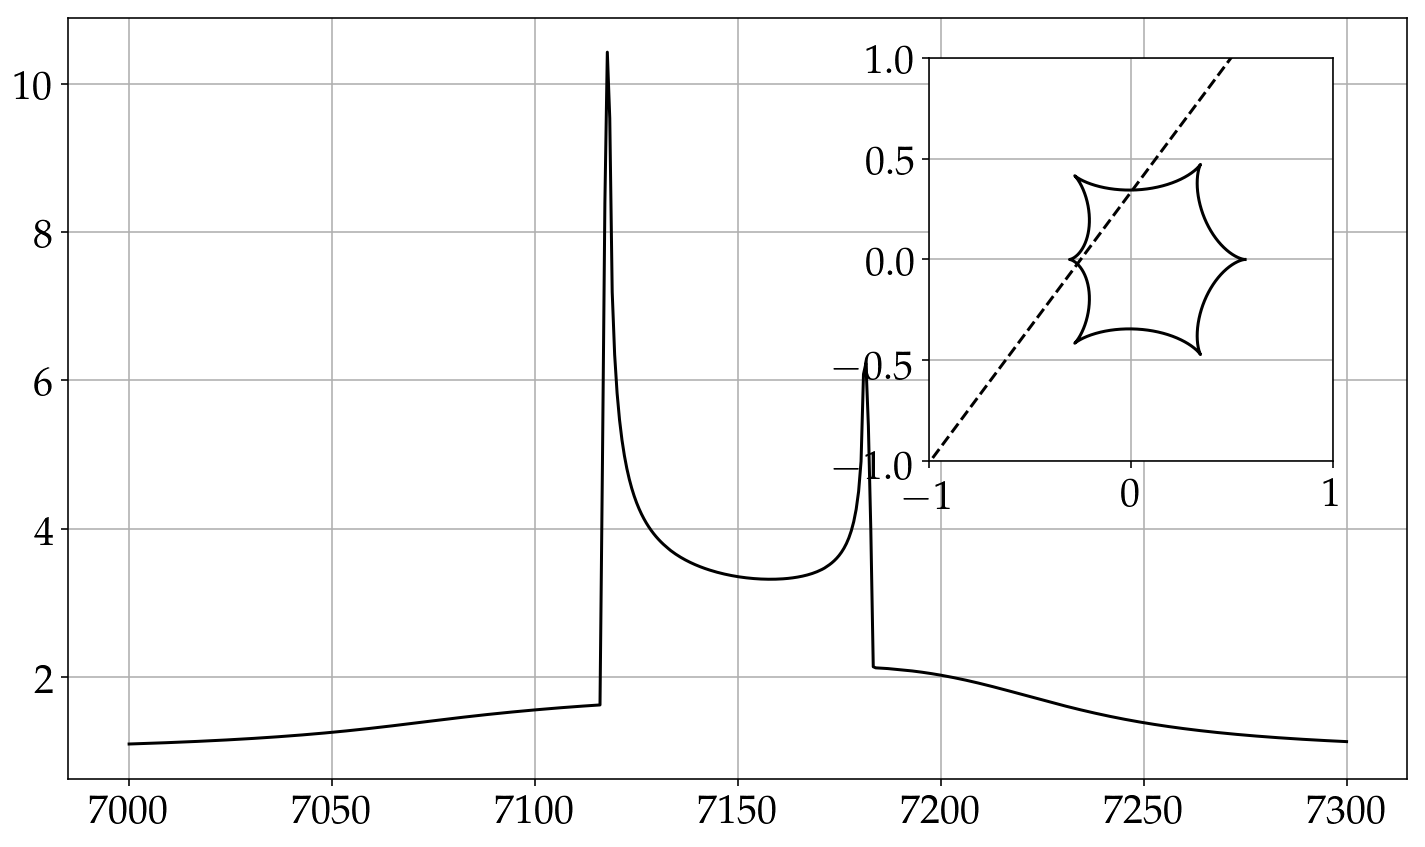

In [103]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(t, mag, 'k-')
ax.grid(True)

ax2 = fig.add_axes([.54, .44, .4, .4], aspect=1)
ax2.plot(caustic_curves[:, 0], caustic_curves[:, 1], 'k-')
ax2.plot(y1, y2, 'k--')
ax2.grid(True)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)

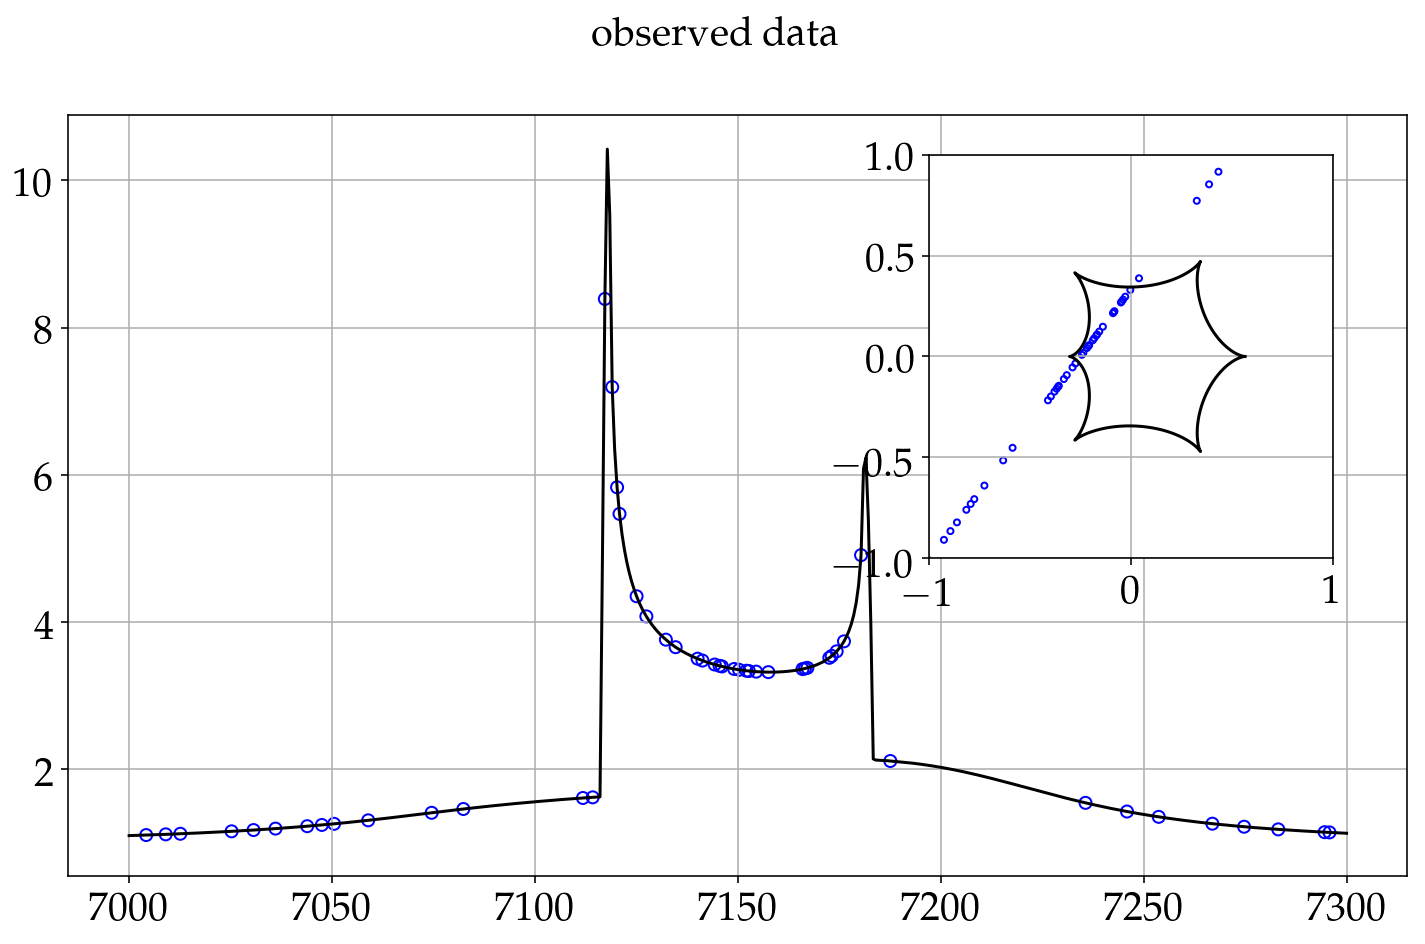

In [104]:
#sample from light curve:
# print(len(t)) #500
Ndata = 50
tindex = np.linspace(0,len(t),len(t), endpoint=False).astype(np.int)
Nsample_index = list(np.random.choice(tindex, size=Ndata, replace=False, p=mag/(np.sum(mag))))
# print(type(Ndatasample))
# print(t[list(Ndatasample)])
# print(type(t[Ndatasample]))
obs_t = t[Nsample_index]
# print(type(mag))
obs_mag = np.array(mag)[Nsample_index]

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(t, mag, 'k-')
ax.grid(True)
ax.scatter(obs_t, obs_mag, marker="o",c='',edgecolors='b')
ax2 = fig.add_axes([.54, .44, .4, .4], aspect=1)
ax2.plot(caustic_curves[:, 0], caustic_curves[:, 1], 'k-')
ax2.scatter(y1[Nsample_index], y2[Nsample_index], marker=".",c='',edgecolors='b')
ax2.grid(True)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
plt.suptitle("observed data", fontsize = 20);


In [105]:
import tensorflow as tf

In [181]:
# using tensorflow to fitting the data to compute the parameters
# now we have observed data: obs_t, obs_mag

# s = 1.2 # separation between the two lenses in units of total ang. Einstein radii
# q = 0.5 # mass ratio: mass of the lens on the right divided by mass of the lens on the left
# rho = 0.01 # source radius in Einstein radii of the total mass.
# alpha = 0.93 # angle between lens axis and source trajectory
# tE = 100.3 # einstein radius crossing time
# t0 = 7154. # time of peak magnification
# u0 = 0.2 # impact parameter

tfs = tf.Variable(1.1) # separation between the two lenses in units of total ang. Einstein radii
tfq = tf.Variable(0.4) # mass ratio: mass of the lens on the right divided by mass of the lens on the left
tfrho = tf.Variable(0.01) # source radius in Einstein radii of the total mass.
tfalpha = tf.Variable(0.9) # angle between lens axis and source trajectory
tftE = tf.Variable(100.) # einstein radius crossing time
tft0 = tf.Variable(7100.0) # time of peak magnification
tfu0 = tf.Variable(0.2) # impact parameter
tfmag = tf.Variable(tf.zeros(len(obs_t,)))#, trainable=False
# Position of the center of the source with respect to the center of mass.
tftau = (obs_t - tft0)/tftE

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

tfy1 = -tfu0*np.sin(sess.run(tfalpha)) + tftau*np.cos(sess.run(tfalpha))
tfy2 = tfu0*np.cos(sess.run(tfalpha)) + tftau*np.sin(sess.run(tfalpha))

magnp = np.zeros(len(obs_t))

# Calculate the magnification at each time 
# ?VBBL.BinaryLightCurve

tfparams = [tf.log(tfs), tf.log(tfq), tfu0, tfalpha, tf.log(tfrho), tf.log(tftE), tft0]
magnp = VBBL.BinaryLightCurve(sess.run(tfparams), obs_t, sess.run(tfy1), sess.run(tfy2))

# loss = tf.reduce_mean(tf.square(tfmag-obs_mag))
assign_op = tfmag.assign(magnp)
sess.run(assign_op)
loss = tf.reduce_mean(tf.square(tfmag - obs_mag))

# print(sess.run(loss))
# optimizer = tf.train.GradientDescentOptimizer(1)
# optimizer = tf.train.AdagradOptimizer(0.1)
# optimizer = tf.train.MomentumOptimizer(0.01, 0.01)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.99, epsilon=1e-08, use_locking=False, name='Adam')

# optimizer = tf.train.RMSPropOptimizer(0.01)

train = optimizer.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)

In [182]:
steptext = "step: {:4}, loss: {:10}"
finaltext = "step: {:4}, loss: {:10}, s: {:5}, q: {:5}, rho: {:5}, alpha: {:5}, tE: {:5}, t0: {:5}, u0: {:5}"
trainstep = int(1e4)
for step in range(trainstep):
    sess.run(assign_op)
    sess.run(train)
    if step % int(trainstep/15) == 0:
        print(steptext.format(step,sess.run(loss)))
print(finaltext.format(step,sess.run(loss),sess.run(tfs),sess.run(tfq),sess.run(tfrho),sess.run(tfalpha),sess.run(tftE),sess.run(tft0),sess.run(tfu0)))


step:    0, loss: 2.316561222076416
step:  666, loss: 2.316561222076416
step: 1332, loss: 2.316561222076416
step: 1998, loss: 2.316561222076416
step: 2664, loss: 2.316561222076416
step: 3330, loss: 2.316561222076416
step: 3996, loss: 2.316561222076416
step: 4662, loss: 2.316561222076416
step: 5328, loss: 2.316561222076416
step: 5994, loss: 2.316561222076416
step: 6660, loss: 2.316561222076416
step: 7326, loss: 2.316561222076416
step: 7992, loss: 2.316561222076416
step: 8658, loss: 2.316561222076416
step: 9324, loss: 2.316561222076416
step: 9990, loss: 2.316561222076416
step: 9999, loss: 2.316561222076416, s: 1.100000023841858, q: 0.4000000059604645, rho: 0.009999999776482582, alpha: 0.8999999761581421, tE: 100.0, t0: 7100.0, u0: 0.20000000298023224


In [163]:
# print("step: {:4}, loss: {:10}".format(10,10))
# s = 1.2 # separation between the two lenses in units of total ang. Einstein radii
# q = 0.5 # mass ratio: mass of the lens on the right divided by mass of the lens on the left
# rho = 0.01 # source radius in Einstein radii of the total mass.
# alpha = 0.93 # angle between lens axis and source trajectory
# tE = 100.3 # einstein radius crossing time
# t0 = 7154. # time of peak magnification
# u0 = 0.2 # impact parameter

In [164]:
#see the fitted parameter by tensorflow is ok or not
# t  =  np.linspace(7000, 7300, 500)
preds = sess.run(tfs) # separation between the two lenses in units of total ang. Einstein radii
predq = sess.run(tfq) # mass ratio: mass of the lens on the right divided by mass of the lens on the left
predrho = sess.run(tfrho) # source radius in Einstein radii of the total mass.
predalpha = sess.run(tfalpha) # angle between lens axis and source trajectory
predtE = sess.run(tftE) # einstein radius crossing time
predt0 = sess.run(tft0) # time of peak magnification
predu0 = sess.run(tfu0) # impact parameter

# Position of the center of the source with respect to the center of mass.
predtau = (t - predt0)/tE
predy1 = -predu0*np.sin(predalpha) + predtau*np.cos(predalpha)
predy2 = predu0*np.cos(predalpha) + predtau*np.sin(predalpha)

predmag = np.zeros(len(predtau))

# Calculate the magnification at each time 
# ?VBBL.BinaryLightCurve

predparams = [np.log(preds), np.log(predq), predu0, predalpha, np.log(predrho), np.log(predtE), predt0]
predmag = VBBL.BinaryLightCurve(predparams, t, predy1, predy2)

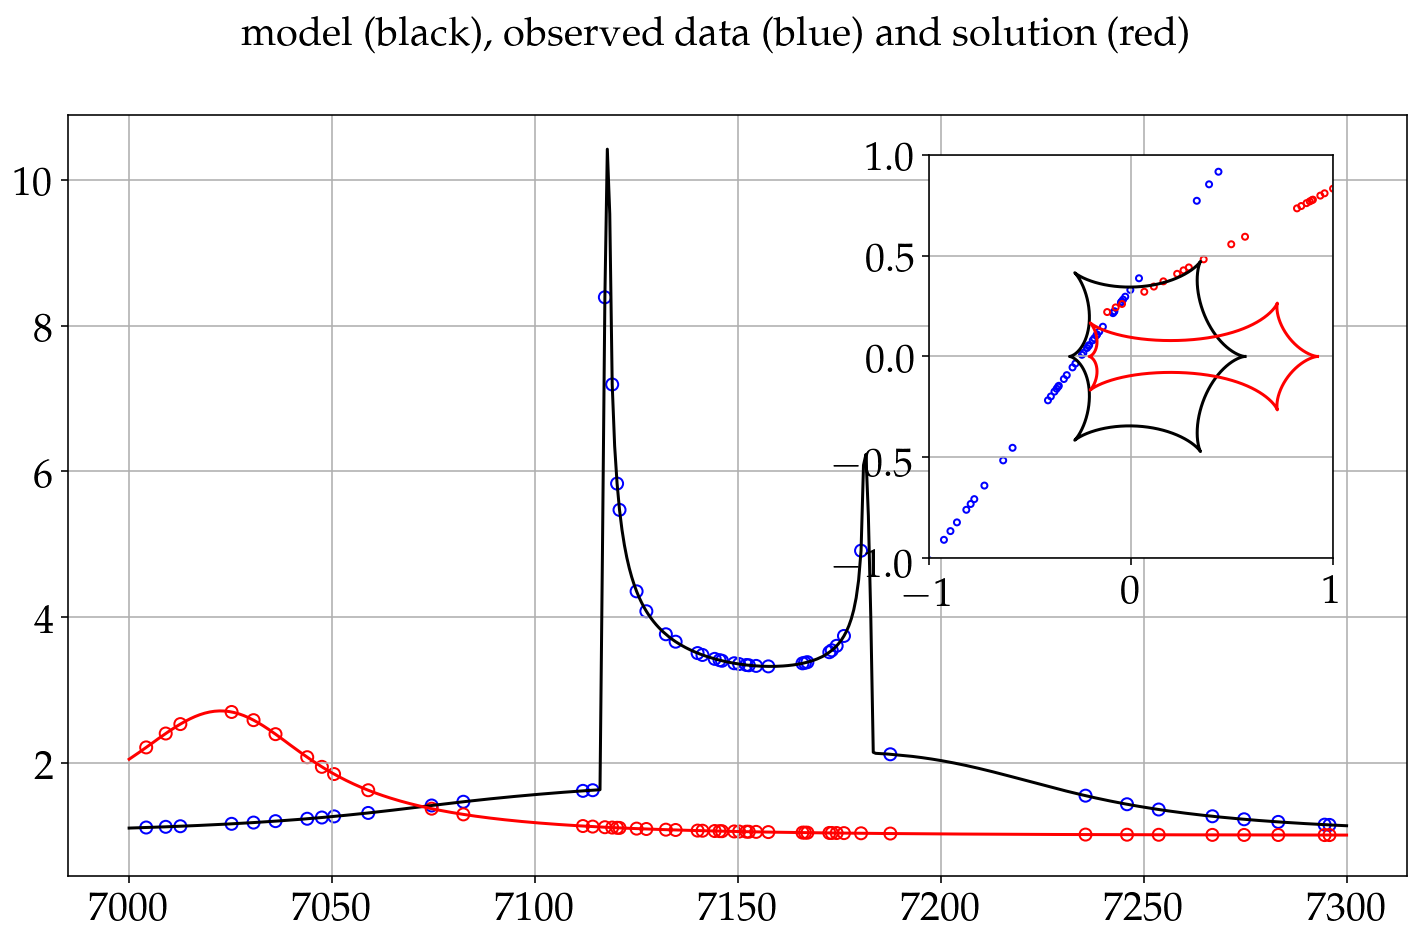

In [165]:
predsolutions = VBBL.PlotCrit(preds, predq)
predcurves = []
for curve in iterate_from(predsolutions.first):
    for point in iterate_from(curve.first):
        predcurves.append((point.x1, point.x2))
        
predcritical_curves = np.array(predcurves[:int(len(predcurves)/2)])
predcaustic_curves = np.array(predcurves[int(len(predcurves)/2):])

tfrespred_mag = np.array(predmag)[Nsample_index]

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(t, mag, 'k-')
ax.plot(t, predmag, 'r-')
ax.grid(True)
ax.scatter(obs_t, obs_mag, marker="o",c='',edgecolors='b')
ax.scatter(obs_t, tfrespred_mag, marker="o",c='',edgecolors='r')
ax2 = fig.add_axes([.54, .44, .4, .4], aspect=1)
ax2.plot(caustic_curves[:, 0], caustic_curves[:, 1], 'k-')
ax2.plot(predcaustic_curves[:, 0], predcaustic_curves[:, 1], 'r-')
ax2.scatter(y1[Nsample_index], y2[Nsample_index], marker=".",c='',edgecolors='b')
ax2.scatter(predy1[Nsample_index], predy2[Nsample_index], marker=".",c='',edgecolors='r')

ax2.grid(True)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
plt.suptitle("model (black), observed data (blue) and solution (red)", fontsize = 20);